# Resolution and Contrast Evaluation

This notebook provides the code for the resolution evaluation on a PICMUS real world data-set. Furthermore, there is the contrast evaluation of a circular echoic region.

The notebook is layed out in a way that two beamformers are applied to the same data and evaluated using the same metrics. It is recommended to leave the first beamformer as a DAS beamformer to have a baseline and use the beamformer class one wants to scrutinize as the second one.

In [1]:
# Import PyBF library
import numpy as np
import sys, os
'''
import sys, os
look here if below import doesn't work: https://stackoverflow.com/questions/7505988/importing-from-a-relative-path-in-python
'''
# sys.path.append('../jupyter')
sys.path.append('.')
from pybf.pybf.io_interfaces import DataLoader
from pybf.scripts.beamformer_DAS_ref import BFCartesianReference
from pybf.scripts.beamformer_mvbf_spatial_smooth import BFMVBFspatial
from pybf.scripts.beamformer_mvbf_DCR import BFMVBFdcr
from pybf.pybf.image_settings import ImageSettings
from pybf.pybf.visualization import plot_image
from pybf.scripts.picmus_eval import PicmusEval

%matplotlib ipympl

### Import data

In [2]:
data_loader_obj = DataLoader('./pybf/tests/data/Picmus/resolution_distorsion/rf_dataset.hdf5')

In [ ]:
tx_temp = data_loader_obj.tx_strategy
print(tx_temp)

 ### Image settings
  
For some beamformers evaluated in the project, the tx_strategy needs to be set up in a way that at least two plane waves need to be emitted from different angles.

 ## Instantiate beamformers

In [ ]:
print("Beamformer 1: DAS")
bf1 = BFCartesianReference(data_loader_obj.f_sampling,
                         tx_strategy,
                         data_loader_obj.transducer,
                         decimation_factor,
                         interpolation_factor,
                         img_res,
                         img_config,
                         start_time=start_time,
                         correction_time_shift=correction_time_shift,
                         alpha_fov_apod=alpha_fov_apod,
                         bp_filter_params=filters_params,
                         envelope_detector='I_Q',
                         picmus_dataset=True,
                         channel_reduction=32)                           # Enter number of active receive channels here

In [ ]:
def create_beamformer(active_elements_list, angle_indices):
    
    # set active transducer elements
    # data_loader_obj.transducer.set_active_elements(active_elements_list)

    img_res = [400, 600]
    image_x_range = [-0.019, 0.019]
    image_z_range = [0.005, 0.05]

    db_range = 50

    LATERAL_PIXEL_DENSITY_DEFAULT = 5

    img_config = ImageSettings(image_x_range[0],
                               image_x_range[1],
                               image_z_range[0],
                               image_z_range[1],
                               LATERAL_PIXEL_DENSITY_DEFAULT,
                               data_loader_obj.transducer)

    ### Specify preprocessing parameters for RF data ###
    decimation_factor = 1
    interpolation_factor = 10

    ### Specify TX strategy and Apodization parameters ###
    start_time = 0
    correction_time_shift = 0

    alpha_fov_apod = 40

    tx_strategy = ['PW_4_2.2', [data_loader_obj.tx_strategy[1][angle_indices[0]], data_loader_obj.tx_strategy[1][angle_indices[1]], data_loader_obj.tx_strategy[1][angle_indices[2]], data_loader_obj.tx_strategy[1][angle_indices[3]]]]
    rf_data_shape = (len(tx_strategy[1]),) + data_loader_obj.get_rf_data(0, 0).shape
    rf_data = np.zeros(rf_data_shape)
    inclin_index = np.asarray(angle_indices)
    for i in range(rf_data.shape[0]):
        rf_data[i, :, :] = data_loader_obj.get_rf_data(0, inclin_index[i])

    SAMPLING_FREQ = data_loader_obj.f_sampling

    filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]

    bf = BFCartesianReference(SAMPLING_FREQ,
                             tx_strategy,
                             data_loader_obj.transducer,
                             decimation_factor,
                             interpolation_factor,
                             img_res,
                             img_config,
                             start_time=start_time,
                             correction_time_shift=correction_time_shift,
                             alpha_fov_apod=alpha_fov_apod,
                             bp_filter_params=filters_params,
                             envelope_detector='I_Q',
                             picmus_dataset=True,
                             channel_reduction=32)

    return bf

In [ ]:
# code to create the beamformer object from function above
# bf1 = create_beamformer(active_elements_list, angle_indices)

In [3]:
active_elements_list = 0
angle_indices = [33, 37, 38, 42]

In [7]:
img_res = [400, 600]
image_x_range = [-0.019, 0.019]
image_z_range = [0.005, 0.05]

db_range = 50

LATERAL_PIXEL_DENSITY_DEFAULT = 5

img_config = ImageSettings(image_x_range[0],
                            image_x_range[1],
                            image_z_range[0],
                            image_z_range[1],
                            LATERAL_PIXEL_DENSITY_DEFAULT,
                            data_loader_obj.transducer)

### Specify preprocessing parameters for RF data ###
decimation_factor = 1
interpolation_factor = 10

### Specify TX strategy and Apodization parameters ###
start_time = 0
correction_time_shift = 0

alpha_fov_apod = 40

tx_strategy = ['PW_4_2.2', [data_loader_obj.tx_strategy[1][angle_indices[0]], data_loader_obj.tx_strategy[1][angle_indices[1]], data_loader_obj.tx_strategy[1][angle_indices[2]], data_loader_obj.tx_strategy[1][angle_indices[3]] ]]
rf_data_shape = (len(tx_strategy[1]),) + data_loader_obj.get_rf_data(0, 0).shape
rf_data = np.zeros(rf_data_shape)
inclin_index = np.asarray(angle_indices)
for i in range(rf_data.shape[0]):
    rf_data[i, :, :] = data_loader_obj.get_rf_data(0, inclin_index[i])

SAMPLING_FREQ = data_loader_obj.f_sampling

filters_params = [1 * 10 **6, 8 * 10 **6, 0.5 * 10 **6]

# channel reduction is the number of channels to be used for beamforming
'''Snipped from beamformer_DAS_ref.py:
start_i = int(np.ceil((ch_nr - channel_reduction)/2))
stop_i = int(start_i + channel_reduction)
'''
channel_reduction = 128

bf = BFCartesianReference(SAMPLING_FREQ,
                            tx_strategy,
                            data_loader_obj.transducer,
                            decimation_factor,
                            interpolation_factor,
                            img_res,
                            img_config,
                            start_time=start_time,
                            correction_time_shift=correction_time_shift,
                            alpha_fov_apod=alpha_fov_apod,
                            bp_filter_params=filters_params,
                            envelope_detector='I_Q',
                            picmus_dataset=True,
                            channel_reduction=channel_reduction)

The highest resolution for the system is:  (633, 205)
Delays precalculation...
TX strategy: plane waves
Number of plane waves:  4
Maximum angle:  2.2 °
Apodization precalculation...


 ## Beamform
 
 Performs the beamforming for the whole image
 
 **Note:** This part of the code is by far the most computationally expensive step. Beamforming using a MVBF beamformer can take several minutes (up to approx. 20 minutes) if a high number of channels is used!

In [8]:
# beamformer 1
print("Img Data for Beamformer 1")
img_data = bf.beamform(rf_data, numba_active=False)

Img Data for Beamformer 1
Beamforming...
 
Time of execution: 20.617170572280884 seconds


In [ ]:
# beamformer 2
print("Img Data for Beamformer 2")
img_data2 = bf2.beamform(rf_data, numba_active=False)

## Evaluations

For both beamformers the Full-Width at Half-Maximum (FWHM) metric is calculated for a number of predefined scatterers in the test data in meters.

### Eval DAS [bf1]

BF Final dB range (-50.0,0.0)


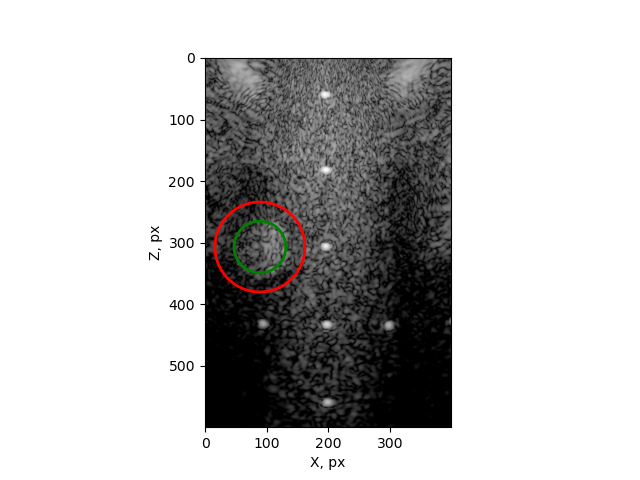

BF Final dB range (-50.0,0.0)


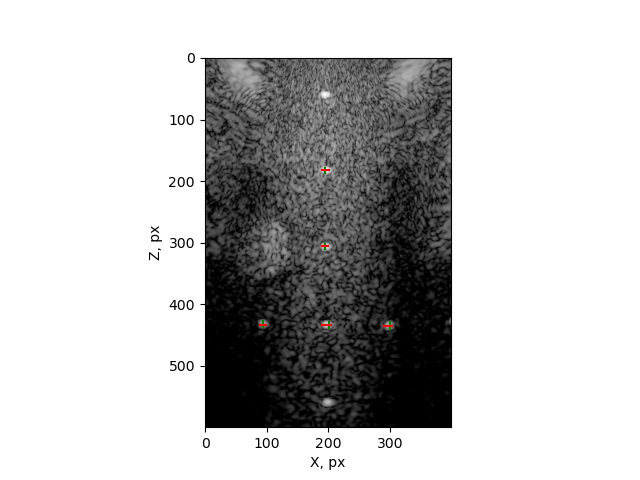

In [9]:
eval_obj = PicmusEval(img_data, bf)
circle_pos = np.asarray([[-0.0105, 0.0281, 0.007, 0.004]])
CNR_values = eval_obj.evaluate_circ_contrast(circle_pos)

scatterer_pos = np.asarray([[-0.001, 0.018, 0.001, 0.001],
                            [-0.001, 0.0277, 0.001, 0.001],
                            [0.0001, 0.0375, 0.001, 0.001],
                           [-0.0104, 0.0375, 0.001, 0.001],
                           [0.0095, 0.0375, 0.001, 0.001]])
FWHM_x, FWHM_y = eval_obj.evaluate_FWHM(scatterer_pos,is_plot=True, plot_name="FWHM_eval")

In [ ]:
print("CNR values are [dB]:")
print(str(CNR_values) + "\n")
print("x-axis FWHM values are [m]:")
print(str(FWHM_x))
print("z-axis FWHM values are [m]:")
print(str(FWHM_y))

### Eval MVBF [bf2]

In [ ]:
eval_obj2 = PicmusEval(img_data2, bf)
CNR_values2 = eval_obj2.evaluate_circ_contrast(circle_pos)
FWHM_x2, FWHM_y2 = eval_obj2.evaluate_FWHM(scatterer_pos)

In [ ]:
print("CNR values are [dB]:")
print(str(CNR_values2) + "\n")
print("x-axis FWHM values are [m]:")
print(str(FWHM_x2))
print("z-axis FWHM values are [m]:")
print(str(FWHM_y2))

 ### Visualize - DAS [bf]

In [ ]:
plot_image(np.abs(img_data), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title='DAS',
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=False, 
               show=True,
               path_to_save='.')


### Visualize - MVBF [bf2]

In [ ]:
plot_image(np.abs(img_data2), 
               scatters_coords_xz=None,
               elements_coords_xz=None,
               framework='matplotlib',
               title='MVBFdcr',
               image_x_range=image_x_range,
               image_z_range=image_z_range,
               db_range=db_range,
               colorscale='Greys',
               save_fig=False, 
               show=True,
               path_to_save='.')